# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

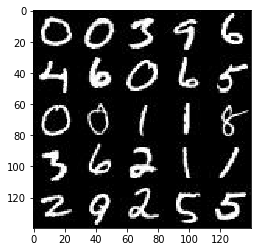

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

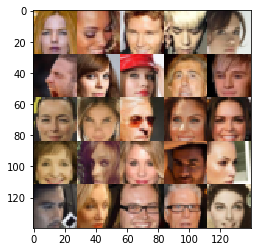

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0


/home/kurazu/workspace/deep-learning-foundation/deep-learning/face_generation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [5]:
# Some fallbacks for old versions of tensorflow (1.3 on AWS)
try:
    leaky_relu = tf.nn.leaky_relu
except AttributeError:
    warnings.warn('Using fallback leaky_relu')
    def leaky_relu(inputs, alpha=0.2):
        return tf.maximum(inputs, inputs * alpha)
    

try:
    flatten = tf.layers.flatten
except AttributeError:
    warnings.warn('Using fallback flatten')
    import functools
    import operator
    
    def flatten(inputs):
        shape = inputs.get_shape()
        target_dim = functools.reduce(operator.mul, map(int, shape[1:]))
        return tf.reshape(inputs, [-1, target_dim])

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    random_inputs = tf.placeholder(tf.float32, shape=[None, z_dim], name='random_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return real_inputs, random_inputs, learning_rate, is_training


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ValueError: too many values to unpack (expected 3)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [44]:
KERNEL_SIZE = 5
STRIDES = 2


def conv2d(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d(
        inputs=inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def dense(inputs, units, is_training, normalization=True, activation=True):
    output = tf.layers.dense(
        inputs=inputs, units=units, use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output
    
    
def discriminator(images, reuse, is_training):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        output = images
        # Shape 28x28xchannels
        output = conv2d(output, 64, is_training, normalization=False)
        # Shape is 14x14x64
        output = conv2d(output, 128, is_training)
        # Shape 7x7x128
        output = conv2d(output, 256, is_training)
        # Shape 4x4x256
        print('discriminator', output.get_shape())
        output = flatten(output)
        # Shape 4*4*256 = 4K
        
        logits = dense(output, 1, is_training, normalization=False, activation=False)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

TypeError: discriminator() missing 2 required positional arguments: 'reuse' and 'is_training'

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def conv2d_transpose(inputs, filters, is_training, normalization=True, activation=True, kernel_size=KERNEL_SIZE):
    output = tf.layers.conv2d_transpose(
        inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output


def generator(z, out_channel_dim, is_training, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=reuse):
        output = dense(z, 4 * 4 * 256, is_training, normalization=False, activation=False)
        output = tf.reshape(output, [-1, 4, 4, 256])
        output = tf.layers.batch_normalization(output, training=is_training)
        output = leaky_relu(output)
        
        # Shape is 4x4x256
        output = conv2d_transpose(output, 128, is_training)
        # Shape is 8x8x128
        output = conv2d_transpose(output, 64, is_training)
        # Shape ix 16x16x64
        output = conv2d_transpose(
            output, out_channel_dim, is_training,
            normalization=False, activation=False
        )
        # Shape is 32x32xout_channel_dim
        output = tf.tanh(output)
        output = tf.image.crop_to_bounding_box(output, 2, 2, 28, 28)
        # Shape is 28x28xout_channel_dim
        print('generator out', output.get_shape())
        
        # tanh generates number in range (-1, 1), but we need to output in range (-.5, .5)
        output *= 0.5
        print('after scaling', output.get_shape())
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

TypeError: generator() missing 1 required positional argument: 'is_training'

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim, is_training):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_training=is_training, reuse=False)
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_real, reuse=False, is_training=is_training
    )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model, reuse=True, is_training=is_training
    )
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real)
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_logits_fake)
    ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_logits_fake)
    ))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

TypeError: model_loss() missing 1 required positional argument: 'is_training'

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            d_loss, var_list=discriminator_variables
        )
        generator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            g_loss, var_list=generator_variables
        )
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, is_training):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_training, reuse=True),
        feed_dict={input_z: example_z, is_training: False}
    )
    print('gen images', n_images, example_z.shape, '->', samples.shape)

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
PRINT_EVERY = 5
VIEW_EVERY = PRINT_EVERY * 3

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    number_of_examples, *_, out_channel_dim = data_shape
    real_images, z, learning_rate_tensor, is_training = model_inputs(*data_shape[1:], z_dim)
    batches_per_epoch = int(number_of_examples / batch_size)
    
    discriminator_loss, generator_loss = model_loss(real_images, z, out_channel_dim, is_training=is_training)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate_tensor, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_images: batch_images,
                    z: batch_z,
                    learning_rate_tensor: learning_rate,
                    is_training: True
                }
                sess.run(discriminator_opt, feed_dict=feed_dict)
                sess.run(generator_opt, feed_dict=feed_dict)
                if step % PRINT_EVERY == 0:
                    train_loss_discriminator = discriminator_loss.eval(feed_dict)
                    train_loss_generator = generator_loss.eval(feed_dict)
                    print(
                        'Epoch {epoch_i}/{epoch_count} '
                        'Step {step}/{steps}: '
                        'Discriminator Loss: {train_loss_discriminator:.4f}. '
                        'Generator Loss: {train_loss_generator:.4f}'.format(
                            epoch_i=epoch_i + 1,
                            epoch_count=epoch_count,
                            step=step,
                            steps=batches_per_epoch * epoch_count,
                            train_loss_generator=train_loss_generator,
                            train_loss_discriminator=train_loss_discriminator
                        )
                    )
                if step % VIEW_EVERY == 0:
                    show_generator_output(sess, 16, z, out_channel_dim, data_image_mode, is_training)
                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
discriminator (?, 4, 4, 256)
discriminator (?, 4, 4, 256)
Epoch 1/2 Step 0/936: Discriminator Loss: 8.4159. Generator Loss: 0.0003
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


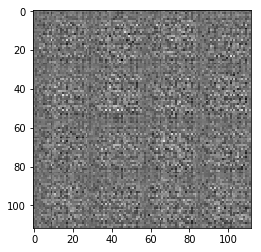

Epoch 1/2 Step 5/936: Discriminator Loss: 0.2977. Generator Loss: 5.7371
Epoch 1/2 Step 10/936: Discriminator Loss: 1.8152. Generator Loss: 0.3821
Epoch 1/2 Step 15/936: Discriminator Loss: 0.7885. Generator Loss: 3.3647
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


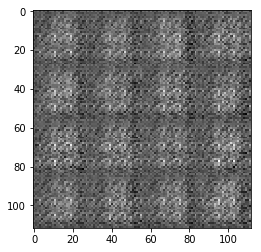

Epoch 1/2 Step 20/936: Discriminator Loss: 2.1871. Generator Loss: 1.4669
Epoch 1/2 Step 25/936: Discriminator Loss: 1.5942. Generator Loss: 5.0059
Epoch 1/2 Step 30/936: Discriminator Loss: 1.7926. Generator Loss: 0.3658
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


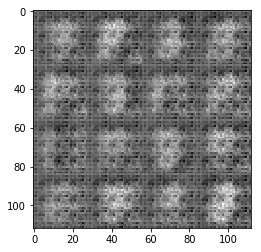

Epoch 1/2 Step 35/936: Discriminator Loss: 1.5618. Generator Loss: 4.3552
Epoch 1/2 Step 40/936: Discriminator Loss: 0.5852. Generator Loss: 1.9740
Epoch 1/2 Step 45/936: Discriminator Loss: 0.6749. Generator Loss: 1.0828
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


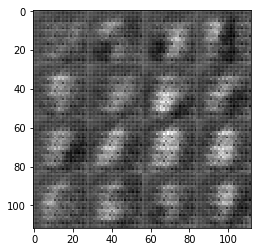

Epoch 1/2 Step 50/936: Discriminator Loss: 0.5361. Generator Loss: 1.6030
Epoch 1/2 Step 55/936: Discriminator Loss: 0.8737. Generator Loss: 4.0733
Epoch 1/2 Step 60/936: Discriminator Loss: 0.5053. Generator Loss: 1.9005
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


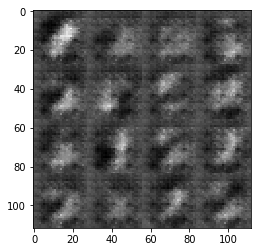

Epoch 1/2 Step 65/936: Discriminator Loss: 0.4647. Generator Loss: 1.7710
Epoch 1/2 Step 70/936: Discriminator Loss: 1.3946. Generator Loss: 0.4543
Epoch 1/2 Step 75/936: Discriminator Loss: 0.9109. Generator Loss: 0.8108
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


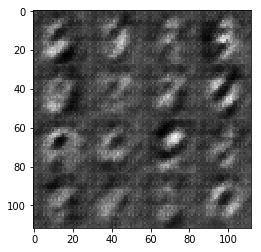

Epoch 1/2 Step 80/936: Discriminator Loss: 0.6612. Generator Loss: 1.3896
Epoch 1/2 Step 85/936: Discriminator Loss: 0.7472. Generator Loss: 1.1518
Epoch 1/2 Step 90/936: Discriminator Loss: 0.7208. Generator Loss: 3.1455
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


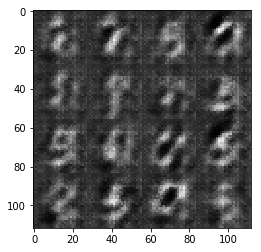

Epoch 1/2 Step 95/936: Discriminator Loss: 1.5087. Generator Loss: 0.3889
Epoch 1/2 Step 100/936: Discriminator Loss: 1.0572. Generator Loss: 0.9907
Epoch 1/2 Step 105/936: Discriminator Loss: 1.0698. Generator Loss: 2.6115
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


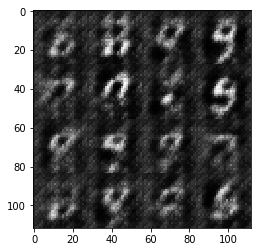

Epoch 1/2 Step 110/936: Discriminator Loss: 0.8441. Generator Loss: 1.4229
Epoch 1/2 Step 115/936: Discriminator Loss: 1.3073. Generator Loss: 0.4736
Epoch 1/2 Step 120/936: Discriminator Loss: 1.1679. Generator Loss: 0.7386
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


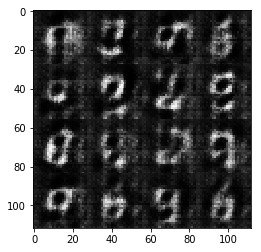

Epoch 1/2 Step 125/936: Discriminator Loss: 0.9112. Generator Loss: 2.0926
Epoch 1/2 Step 130/936: Discriminator Loss: 1.2562. Generator Loss: 2.7355
Epoch 1/2 Step 135/936: Discriminator Loss: 1.0767. Generator Loss: 1.2835
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


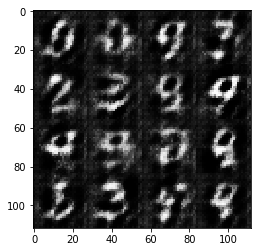

Epoch 1/2 Step 140/936: Discriminator Loss: 1.3092. Generator Loss: 0.4919
Epoch 1/2 Step 145/936: Discriminator Loss: 0.9094. Generator Loss: 0.9333
Epoch 1/2 Step 150/936: Discriminator Loss: 0.6487. Generator Loss: 1.7110
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


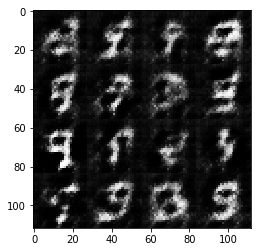

Epoch 1/2 Step 155/936: Discriminator Loss: 0.7672. Generator Loss: 2.1478
Epoch 1/2 Step 160/936: Discriminator Loss: 1.2251. Generator Loss: 2.3201
Epoch 1/2 Step 165/936: Discriminator Loss: 0.7788. Generator Loss: 1.6022
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


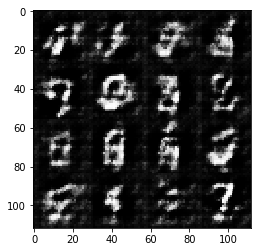

Epoch 1/2 Step 170/936: Discriminator Loss: 0.7977. Generator Loss: 1.0064
Epoch 1/2 Step 175/936: Discriminator Loss: 0.9686. Generator Loss: 1.8111
Epoch 1/2 Step 180/936: Discriminator Loss: 0.9071. Generator Loss: 1.2467
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


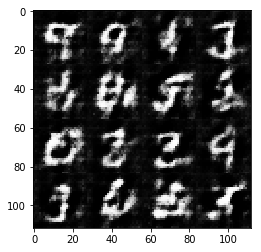

Epoch 1/2 Step 185/936: Discriminator Loss: 0.6419. Generator Loss: 1.3500
Epoch 1/2 Step 190/936: Discriminator Loss: 0.8600. Generator Loss: 1.0557
Epoch 1/2 Step 195/936: Discriminator Loss: 0.9034. Generator Loss: 2.5230
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


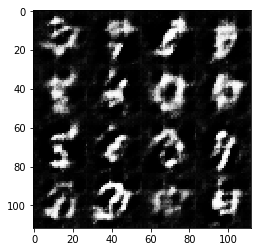

Epoch 1/2 Step 200/936: Discriminator Loss: 0.8533. Generator Loss: 1.4092
Epoch 1/2 Step 205/936: Discriminator Loss: 0.8654. Generator Loss: 0.8844
Epoch 1/2 Step 210/936: Discriminator Loss: 0.7748. Generator Loss: 1.0063
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


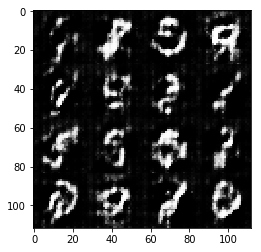

Epoch 1/2 Step 215/936: Discriminator Loss: 0.9310. Generator Loss: 0.7903
Epoch 1/2 Step 220/936: Discriminator Loss: 0.9301. Generator Loss: 2.5178
Epoch 1/2 Step 225/936: Discriminator Loss: 0.8069. Generator Loss: 1.0568
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


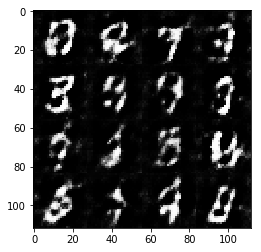

Epoch 1/2 Step 230/936: Discriminator Loss: 0.8326. Generator Loss: 1.2594
Epoch 1/2 Step 235/936: Discriminator Loss: 0.6014. Generator Loss: 1.3905
Epoch 1/2 Step 240/936: Discriminator Loss: 0.7885. Generator Loss: 1.7288
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


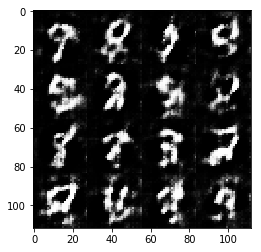

Epoch 1/2 Step 245/936: Discriminator Loss: 0.6633. Generator Loss: 1.3752
Epoch 1/2 Step 250/936: Discriminator Loss: 0.7684. Generator Loss: 1.0207
Epoch 1/2 Step 255/936: Discriminator Loss: 0.7912. Generator Loss: 2.4283
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


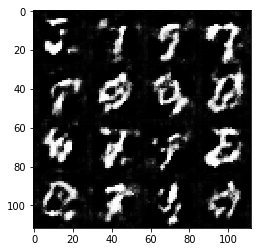

Epoch 1/2 Step 260/936: Discriminator Loss: 0.8344. Generator Loss: 0.8419
Epoch 1/2 Step 265/936: Discriminator Loss: 0.5974. Generator Loss: 1.4138
Epoch 1/2 Step 270/936: Discriminator Loss: 0.8078. Generator Loss: 2.3767
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


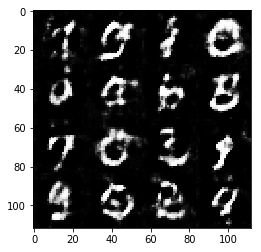

Epoch 1/2 Step 275/936: Discriminator Loss: 0.8639. Generator Loss: 0.8672
Epoch 1/2 Step 280/936: Discriminator Loss: 0.6828. Generator Loss: 1.2451
Epoch 1/2 Step 285/936: Discriminator Loss: 0.8419. Generator Loss: 3.2198
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


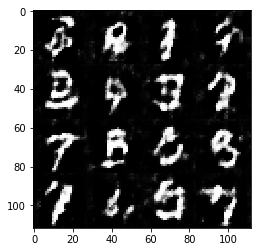

Epoch 1/2 Step 290/936: Discriminator Loss: 0.6595. Generator Loss: 2.0009
Epoch 1/2 Step 295/936: Discriminator Loss: 0.9816. Generator Loss: 0.6918
Epoch 1/2 Step 300/936: Discriminator Loss: 0.7099. Generator Loss: 1.3244
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


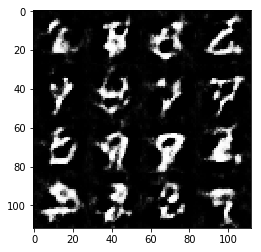

Epoch 1/2 Step 305/936: Discriminator Loss: 0.5712. Generator Loss: 1.8849
Epoch 1/2 Step 310/936: Discriminator Loss: 0.9285. Generator Loss: 0.8182
Epoch 1/2 Step 315/936: Discriminator Loss: 0.9806. Generator Loss: 0.7696
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


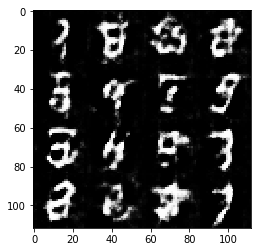

Epoch 1/2 Step 320/936: Discriminator Loss: 0.6513. Generator Loss: 1.5351
Epoch 1/2 Step 325/936: Discriminator Loss: 0.6164. Generator Loss: 2.2300
Epoch 1/2 Step 330/936: Discriminator Loss: 0.8062. Generator Loss: 1.1934
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


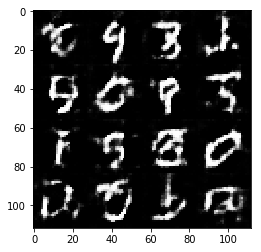

Epoch 1/2 Step 335/936: Discriminator Loss: 0.8776. Generator Loss: 3.0288
Epoch 1/2 Step 340/936: Discriminator Loss: 0.8270. Generator Loss: 1.6686
Epoch 1/2 Step 345/936: Discriminator Loss: 0.7516. Generator Loss: 1.1870
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


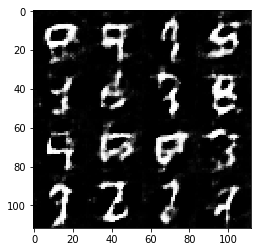

Epoch 1/2 Step 350/936: Discriminator Loss: 0.8308. Generator Loss: 1.7144
Epoch 1/2 Step 355/936: Discriminator Loss: 0.6634. Generator Loss: 1.3150
Epoch 1/2 Step 360/936: Discriminator Loss: 1.5524. Generator Loss: 0.4083
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


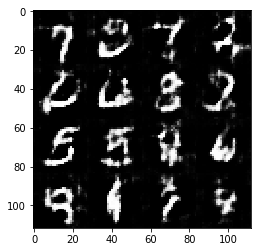

Epoch 1/2 Step 365/936: Discriminator Loss: 0.8657. Generator Loss: 1.0686
Epoch 1/2 Step 370/936: Discriminator Loss: 0.8414. Generator Loss: 0.8152
Epoch 1/2 Step 375/936: Discriminator Loss: 0.7422. Generator Loss: 1.4786
generator out (?, 28, 28, 1)
after scaling (?, 28, 28, 1)
gen images 16 (16, 100) -> (16, 28, 28, 1)


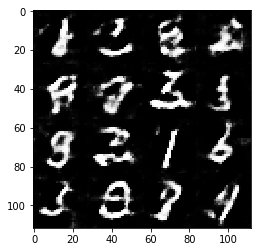

Epoch 1/2 Step 380/936: Discriminator Loss: 0.8826. Generator Loss: 2.2711
Epoch 1/2 Step 385/936: Discriminator Loss: 0.8975. Generator Loss: 0.8679


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator out (?, 28, 28, 3)
discriminator (?, 4, 4, 256)
discriminator (?, 4, 4, 256)
Epoch 1/1 Step 0/1582: Discriminator Loss: 1.7878. Generator Loss: 0.3069
generator out (?, 28, 28, 3)


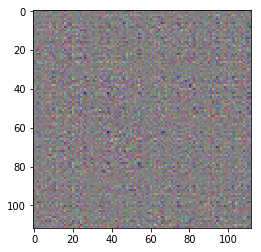

Epoch 1/1 Step 5/1582: Discriminator Loss: 0.3676. Generator Loss: 1.8337
Epoch 1/1 Step 10/1582: Discriminator Loss: 0.2326. Generator Loss: 2.3189
Epoch 1/1 Step 15/1582: Discriminator Loss: 0.1898. Generator Loss: 2.4988
generator out (?, 28, 28, 3)


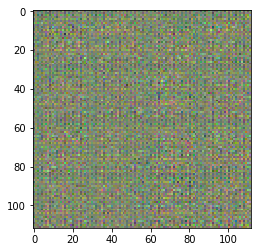

Epoch 1/1 Step 20/1582: Discriminator Loss: 0.1603. Generator Loss: 2.4945
Epoch 1/1 Step 25/1582: Discriminator Loss: 0.1207. Generator Loss: 2.8605
Epoch 1/1 Step 30/1582: Discriminator Loss: 0.1755. Generator Loss: 5.0880
generator out (?, 28, 28, 3)


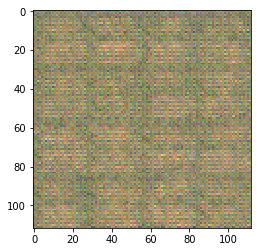

Epoch 1/1 Step 35/1582: Discriminator Loss: 0.1809. Generator Loss: 2.6586
Epoch 1/1 Step 40/1582: Discriminator Loss: 0.3550. Generator Loss: 6.3531
Epoch 1/1 Step 45/1582: Discriminator Loss: 1.8453. Generator Loss: 0.2406
generator out (?, 28, 28, 3)


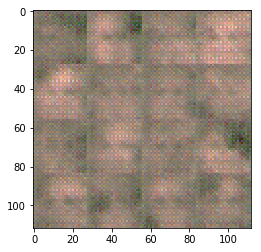

Epoch 1/1 Step 50/1582: Discriminator Loss: 0.8910. Generator Loss: 0.8559
Epoch 1/1 Step 55/1582: Discriminator Loss: 2.2655. Generator Loss: 0.1608
Epoch 1/1 Step 60/1582: Discriminator Loss: 0.4088. Generator Loss: 1.7442
generator out (?, 28, 28, 3)


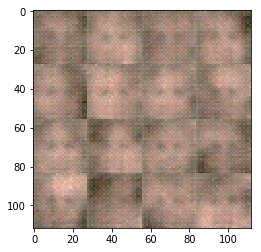

Epoch 1/1 Step 65/1582: Discriminator Loss: 0.5704. Generator Loss: 1.0885
Epoch 1/1 Step 70/1582: Discriminator Loss: 0.5180. Generator Loss: 1.1628
Epoch 1/1 Step 75/1582: Discriminator Loss: 0.2151. Generator Loss: 2.8298
generator out (?, 28, 28, 3)


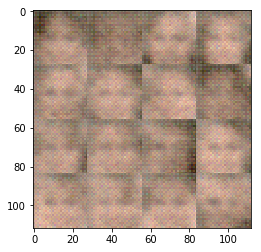

Epoch 1/1 Step 80/1582: Discriminator Loss: 0.2080. Generator Loss: 2.8930
Epoch 1/1 Step 85/1582: Discriminator Loss: 0.1541. Generator Loss: 2.3668
Epoch 1/1 Step 90/1582: Discriminator Loss: 0.0804. Generator Loss: 3.2496
generator out (?, 28, 28, 3)


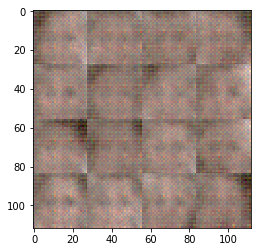

Epoch 1/1 Step 95/1582: Discriminator Loss: 2.3531. Generator Loss: 0.2830
Epoch 1/1 Step 100/1582: Discriminator Loss: 0.2333. Generator Loss: 4.6919
Epoch 1/1 Step 105/1582: Discriminator Loss: 0.1002. Generator Loss: 3.2405
generator out (?, 28, 28, 3)


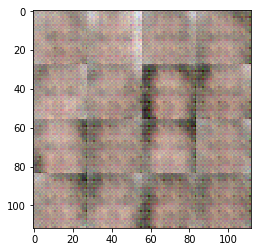

Epoch 1/1 Step 110/1582: Discriminator Loss: 4.4016. Generator Loss: 12.9584
Epoch 1/1 Step 115/1582: Discriminator Loss: 0.8910. Generator Loss: 0.9238
Epoch 1/1 Step 120/1582: Discriminator Loss: 0.4384. Generator Loss: 2.5137
generator out (?, 28, 28, 3)


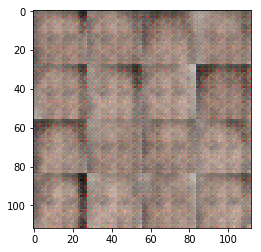

Epoch 1/1 Step 125/1582: Discriminator Loss: 0.8389. Generator Loss: 0.8358
Epoch 1/1 Step 130/1582: Discriminator Loss: 0.4220. Generator Loss: 3.0955
Epoch 1/1 Step 135/1582: Discriminator Loss: 1.9817. Generator Loss: 7.2776
generator out (?, 28, 28, 3)


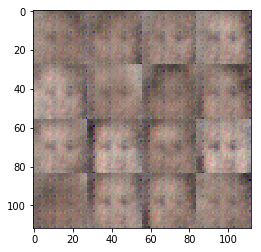

Epoch 1/1 Step 140/1582: Discriminator Loss: 0.8774. Generator Loss: 7.3645
Epoch 1/1 Step 145/1582: Discriminator Loss: 0.5185. Generator Loss: 5.5014
Epoch 1/1 Step 150/1582: Discriminator Loss: 0.7540. Generator Loss: 0.8651
generator out (?, 28, 28, 3)


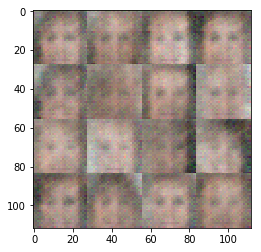

Epoch 1/1 Step 155/1582: Discriminator Loss: 0.3181. Generator Loss: 2.0687
Epoch 1/1 Step 160/1582: Discriminator Loss: 0.5424. Generator Loss: 2.4413
Epoch 1/1 Step 165/1582: Discriminator Loss: 0.4736. Generator Loss: 2.5251
generator out (?, 28, 28, 3)


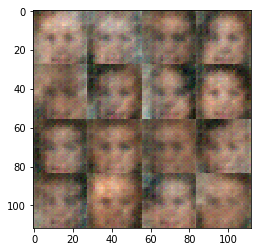

Epoch 1/1 Step 170/1582: Discriminator Loss: 0.3014. Generator Loss: 2.0333
Epoch 1/1 Step 175/1582: Discriminator Loss: 0.7255. Generator Loss: 6.1143
Epoch 1/1 Step 180/1582: Discriminator Loss: 0.8288. Generator Loss: 6.0053
generator out (?, 28, 28, 3)


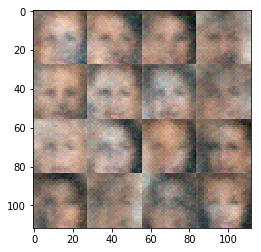

Epoch 1/1 Step 185/1582: Discriminator Loss: 1.8283. Generator Loss: 5.1337
Epoch 1/1 Step 190/1582: Discriminator Loss: 0.4927. Generator Loss: 2.8463
Epoch 1/1 Step 195/1582: Discriminator Loss: 0.4382. Generator Loss: 2.2170
generator out (?, 28, 28, 3)


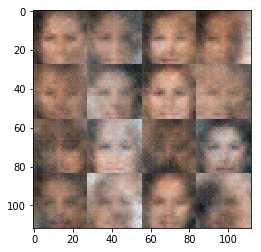

Epoch 1/1 Step 200/1582: Discriminator Loss: 0.4560. Generator Loss: 3.9684
Epoch 1/1 Step 205/1582: Discriminator Loss: 0.3457. Generator Loss: 2.5401
Epoch 1/1 Step 210/1582: Discriminator Loss: 0.6265. Generator Loss: 3.6978
generator out (?, 28, 28, 3)


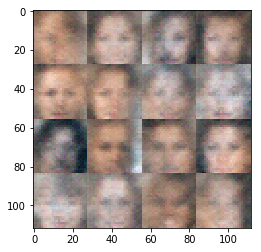

Epoch 1/1 Step 215/1582: Discriminator Loss: 0.3539. Generator Loss: 3.1022
Epoch 1/1 Step 220/1582: Discriminator Loss: 0.1520. Generator Loss: 3.9749
Epoch 1/1 Step 225/1582: Discriminator Loss: 0.1632. Generator Loss: 3.1870
generator out (?, 28, 28, 3)


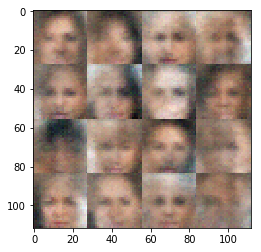

Epoch 1/1 Step 230/1582: Discriminator Loss: 0.2070. Generator Loss: 2.3986
Epoch 1/1 Step 235/1582: Discriminator Loss: 1.1201. Generator Loss: 0.5135
Epoch 1/1 Step 240/1582: Discriminator Loss: 0.1035. Generator Loss: 5.2486
generator out (?, 28, 28, 3)


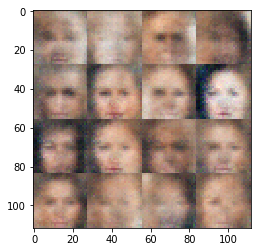

Epoch 1/1 Step 245/1582: Discriminator Loss: 1.4638. Generator Loss: 0.3989
Epoch 1/1 Step 250/1582: Discriminator Loss: 0.0995. Generator Loss: 3.5226
Epoch 1/1 Step 255/1582: Discriminator Loss: 0.1725. Generator Loss: 2.8728
generator out (?, 28, 28, 3)


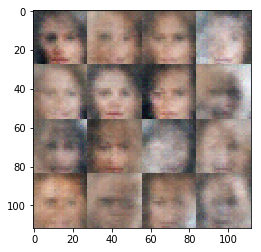

Epoch 1/1 Step 260/1582: Discriminator Loss: 0.0825. Generator Loss: 3.6154
Epoch 1/1 Step 265/1582: Discriminator Loss: 0.1080. Generator Loss: 3.9328
Epoch 1/1 Step 270/1582: Discriminator Loss: 2.0908. Generator Loss: 0.1857
generator out (?, 28, 28, 3)


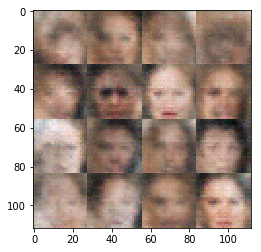

Epoch 1/1 Step 275/1582: Discriminator Loss: 0.2759. Generator Loss: 3.2227
Epoch 1/1 Step 280/1582: Discriminator Loss: 0.2715. Generator Loss: 2.0013
Epoch 1/1 Step 285/1582: Discriminator Loss: 0.1540. Generator Loss: 5.6558
generator out (?, 28, 28, 3)


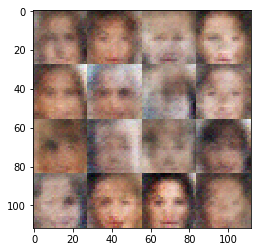

Epoch 1/1 Step 290/1582: Discriminator Loss: 0.2969. Generator Loss: 8.1286
Epoch 1/1 Step 295/1582: Discriminator Loss: 0.2486. Generator Loss: 2.4199
Epoch 1/1 Step 300/1582: Discriminator Loss: 0.1126. Generator Loss: 3.6962
generator out (?, 28, 28, 3)


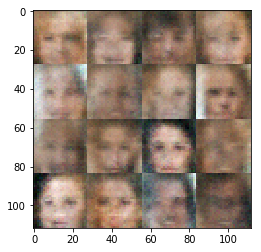

Epoch 1/1 Step 305/1582: Discriminator Loss: 0.1340. Generator Loss: 3.0101
Epoch 1/1 Step 310/1582: Discriminator Loss: 0.2626. Generator Loss: 1.8473
Epoch 1/1 Step 315/1582: Discriminator Loss: 0.9157. Generator Loss: 6.1854
generator out (?, 28, 28, 3)


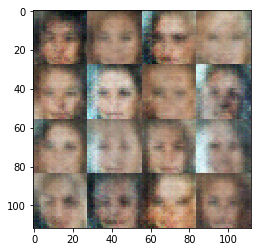

Epoch 1/1 Step 320/1582: Discriminator Loss: 0.6142. Generator Loss: 1.3453
Epoch 1/1 Step 325/1582: Discriminator Loss: 0.1815. Generator Loss: 2.0836
Epoch 1/1 Step 330/1582: Discriminator Loss: 1.7243. Generator Loss: 0.2561
generator out (?, 28, 28, 3)


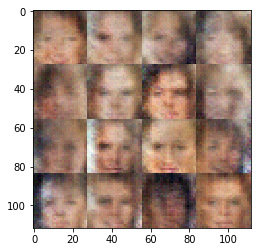

Epoch 1/1 Step 335/1582: Discriminator Loss: 2.3718. Generator Loss: 3.5704
Epoch 1/1 Step 340/1582: Discriminator Loss: 0.7329. Generator Loss: 0.9272
Epoch 1/1 Step 345/1582: Discriminator Loss: 0.1010. Generator Loss: 4.2051
generator out (?, 28, 28, 3)


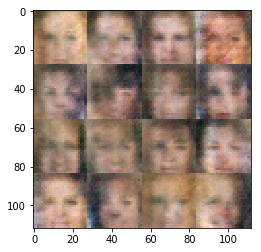

Epoch 1/1 Step 350/1582: Discriminator Loss: 0.3883. Generator Loss: 5.1427
Epoch 1/1 Step 355/1582: Discriminator Loss: 0.1765. Generator Loss: 3.0041
Epoch 1/1 Step 360/1582: Discriminator Loss: 0.3852. Generator Loss: 1.4762
generator out (?, 28, 28, 3)


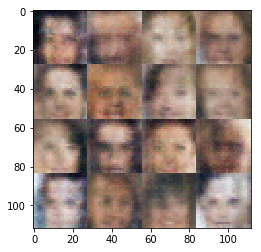

Epoch 1/1 Step 365/1582: Discriminator Loss: 0.3030. Generator Loss: 3.1382
Epoch 1/1 Step 370/1582: Discriminator Loss: 0.2964. Generator Loss: 2.0292
Epoch 1/1 Step 375/1582: Discriminator Loss: 1.6221. Generator Loss: 4.9534
generator out (?, 28, 28, 3)


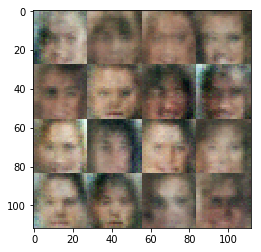

Epoch 1/1 Step 380/1582: Discriminator Loss: 0.3767. Generator Loss: 1.9841
Epoch 1/1 Step 385/1582: Discriminator Loss: 0.0621. Generator Loss: 7.5166
Epoch 1/1 Step 390/1582: Discriminator Loss: 0.4300. Generator Loss: 1.6360
generator out (?, 28, 28, 3)


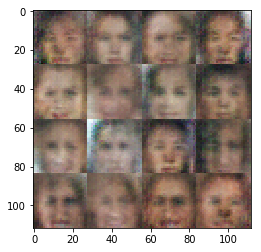

Epoch 1/1 Step 395/1582: Discriminator Loss: 0.2148. Generator Loss: 2.6607
Epoch 1/1 Step 400/1582: Discriminator Loss: 0.2257. Generator Loss: 2.7141
Epoch 1/1 Step 405/1582: Discriminator Loss: 0.1393. Generator Loss: 4.3675
generator out (?, 28, 28, 3)


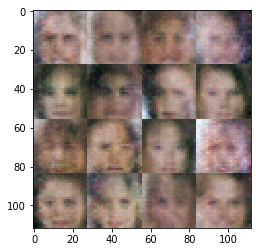

Epoch 1/1 Step 410/1582: Discriminator Loss: 1.1603. Generator Loss: 3.7723
Epoch 1/1 Step 415/1582: Discriminator Loss: 0.3741. Generator Loss: 2.7853
Epoch 1/1 Step 420/1582: Discriminator Loss: 0.5623. Generator Loss: 1.2194
generator out (?, 28, 28, 3)


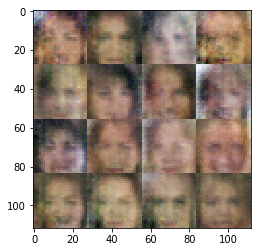

Epoch 1/1 Step 425/1582: Discriminator Loss: 0.1394. Generator Loss: 3.0182
Epoch 1/1 Step 430/1582: Discriminator Loss: 1.6309. Generator Loss: 0.2854
Epoch 1/1 Step 435/1582: Discriminator Loss: 0.5800. Generator Loss: 1.0568
generator out (?, 28, 28, 3)


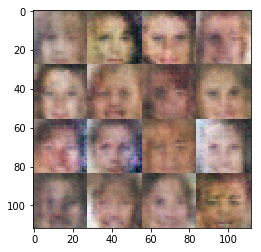

Epoch 1/1 Step 440/1582: Discriminator Loss: 0.3251. Generator Loss: 2.7826
Epoch 1/1 Step 445/1582: Discriminator Loss: 0.2649. Generator Loss: 2.2582
Epoch 1/1 Step 450/1582: Discriminator Loss: 0.2839. Generator Loss: 2.1286
generator out (?, 28, 28, 3)


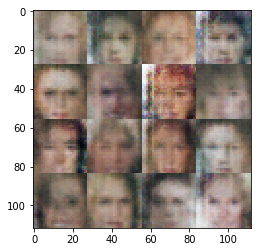

Epoch 1/1 Step 455/1582: Discriminator Loss: 0.6447. Generator Loss: 7.0680
Epoch 1/1 Step 460/1582: Discriminator Loss: 0.2563. Generator Loss: 2.2470
Epoch 1/1 Step 465/1582: Discriminator Loss: 0.3149. Generator Loss: 2.0603
generator out (?, 28, 28, 3)


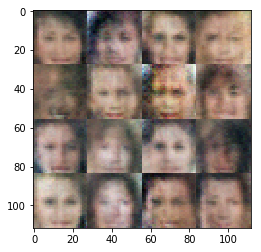

Epoch 1/1 Step 470/1582: Discriminator Loss: 0.1909. Generator Loss: 2.8600
Epoch 1/1 Step 475/1582: Discriminator Loss: 0.1777. Generator Loss: 2.8057
Epoch 1/1 Step 480/1582: Discriminator Loss: 0.9841. Generator Loss: 0.6343
generator out (?, 28, 28, 3)


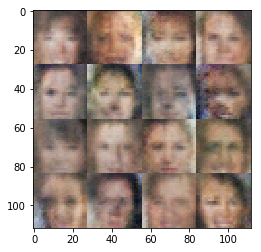

Epoch 1/1 Step 485/1582: Discriminator Loss: 0.2839. Generator Loss: 2.0854
Epoch 1/1 Step 490/1582: Discriminator Loss: 0.2959. Generator Loss: 2.0027
Epoch 1/1 Step 495/1582: Discriminator Loss: 0.2028. Generator Loss: 3.1177
generator out (?, 28, 28, 3)


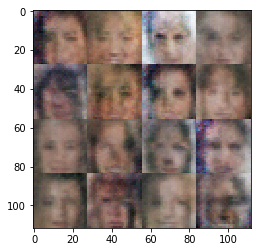

Epoch 1/1 Step 500/1582: Discriminator Loss: 0.1078. Generator Loss: 4.8320
Epoch 1/1 Step 505/1582: Discriminator Loss: 0.1793. Generator Loss: 4.7720
Epoch 1/1 Step 510/1582: Discriminator Loss: 0.2136. Generator Loss: 2.5811
generator out (?, 28, 28, 3)


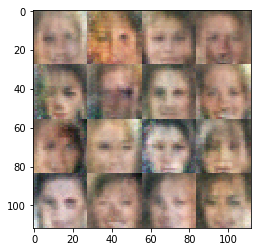

Epoch 1/1 Step 515/1582: Discriminator Loss: 0.4913. Generator Loss: 1.2721
Epoch 1/1 Step 520/1582: Discriminator Loss: 0.1725. Generator Loss: 3.8675
Epoch 1/1 Step 525/1582: Discriminator Loss: 0.1458. Generator Loss: 3.4099
generator out (?, 28, 28, 3)


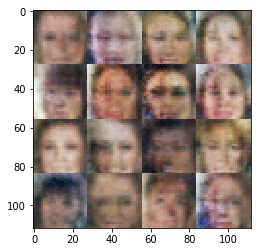

Epoch 1/1 Step 530/1582: Discriminator Loss: 0.2781. Generator Loss: 2.4715
Epoch 1/1 Step 535/1582: Discriminator Loss: 0.2836. Generator Loss: 2.0197
Epoch 1/1 Step 540/1582: Discriminator Loss: 0.2349. Generator Loss: 2.8954
generator out (?, 28, 28, 3)


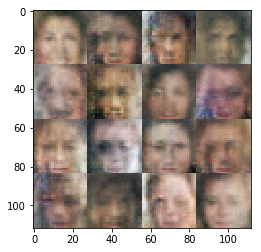

Epoch 1/1 Step 545/1582: Discriminator Loss: 0.6400. Generator Loss: 2.0624
Epoch 1/1 Step 550/1582: Discriminator Loss: 1.4268. Generator Loss: 2.1080
Epoch 1/1 Step 555/1582: Discriminator Loss: 1.0482. Generator Loss: 1.2234
generator out (?, 28, 28, 3)


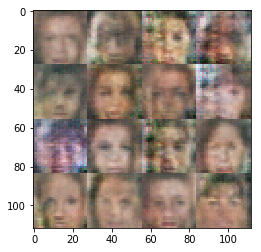

Epoch 1/1 Step 560/1582: Discriminator Loss: 0.5000. Generator Loss: 3.2167
Epoch 1/1 Step 565/1582: Discriminator Loss: 0.5430. Generator Loss: 1.9334
Epoch 1/1 Step 570/1582: Discriminator Loss: 0.4421. Generator Loss: 2.1356
generator out (?, 28, 28, 3)


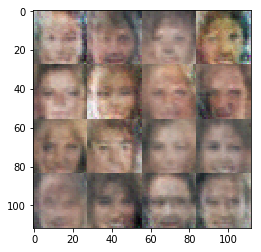

Epoch 1/1 Step 575/1582: Discriminator Loss: 0.9362. Generator Loss: 3.3661
Epoch 1/1 Step 580/1582: Discriminator Loss: 0.5273. Generator Loss: 1.3152
Epoch 1/1 Step 585/1582: Discriminator Loss: 0.2939. Generator Loss: 2.5845
generator out (?, 28, 28, 3)


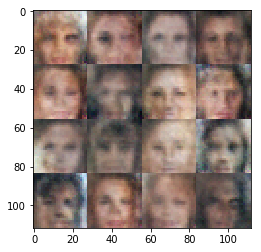

Epoch 1/1 Step 590/1582: Discriminator Loss: 0.2579. Generator Loss: 3.5119
Epoch 1/1 Step 595/1582: Discriminator Loss: 0.1385. Generator Loss: 3.5338
Epoch 1/1 Step 600/1582: Discriminator Loss: 0.1528. Generator Loss: 4.7359
generator out (?, 28, 28, 3)


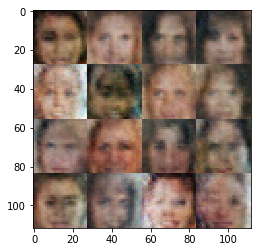

Epoch 1/1 Step 605/1582: Discriminator Loss: 1.2799. Generator Loss: 0.4104
Epoch 1/1 Step 610/1582: Discriminator Loss: 0.3982. Generator Loss: 3.1702
Epoch 1/1 Step 615/1582: Discriminator Loss: 0.3767. Generator Loss: 1.6091
generator out (?, 28, 28, 3)


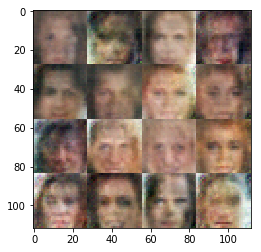

Epoch 1/1 Step 620/1582: Discriminator Loss: 0.2800. Generator Loss: 2.0624
Epoch 1/1 Step 625/1582: Discriminator Loss: 1.0657. Generator Loss: 0.5825
Epoch 1/1 Step 630/1582: Discriminator Loss: 1.7525. Generator Loss: 0.2410
generator out (?, 28, 28, 3)


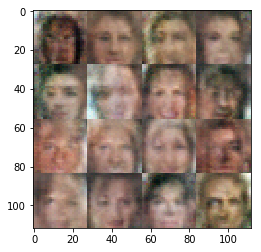

Epoch 1/1 Step 635/1582: Discriminator Loss: 0.8125. Generator Loss: 0.8407
Epoch 1/1 Step 640/1582: Discriminator Loss: 0.5190. Generator Loss: 1.5387
Epoch 1/1 Step 645/1582: Discriminator Loss: 0.8514. Generator Loss: 0.7976
generator out (?, 28, 28, 3)


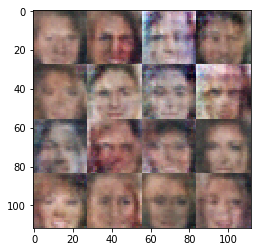

Epoch 1/1 Step 650/1582: Discriminator Loss: 1.1864. Generator Loss: 3.9499
Epoch 1/1 Step 655/1582: Discriminator Loss: 0.3494. Generator Loss: 2.5493
Epoch 1/1 Step 660/1582: Discriminator Loss: 0.4602. Generator Loss: 3.5039
generator out (?, 28, 28, 3)


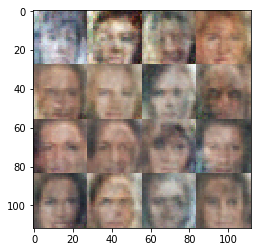

Epoch 1/1 Step 665/1582: Discriminator Loss: 0.1663. Generator Loss: 4.3496
Epoch 1/1 Step 670/1582: Discriminator Loss: 0.2562. Generator Loss: 2.3957
Epoch 1/1 Step 675/1582: Discriminator Loss: 0.2709. Generator Loss: 2.3489
generator out (?, 28, 28, 3)


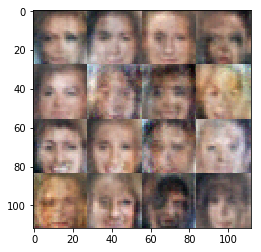

Epoch 1/1 Step 680/1582: Discriminator Loss: 0.2162. Generator Loss: 3.0067
Epoch 1/1 Step 685/1582: Discriminator Loss: 0.4063. Generator Loss: 1.7098
Epoch 1/1 Step 690/1582: Discriminator Loss: 0.1350. Generator Loss: 3.4702
generator out (?, 28, 28, 3)


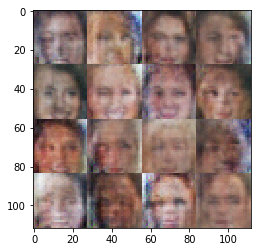

Epoch 1/1 Step 695/1582: Discriminator Loss: 0.2374. Generator Loss: 4.7725
Epoch 1/1 Step 700/1582: Discriminator Loss: 0.1969. Generator Loss: 2.6270
Epoch 1/1 Step 705/1582: Discriminator Loss: 0.6485. Generator Loss: 1.2104
generator out (?, 28, 28, 3)


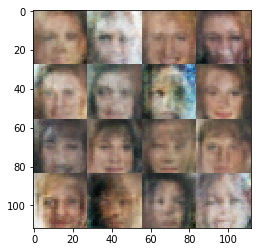

Epoch 1/1 Step 710/1582: Discriminator Loss: 1.3574. Generator Loss: 8.2601
Epoch 1/1 Step 715/1582: Discriminator Loss: 1.0974. Generator Loss: 3.5460
Epoch 1/1 Step 720/1582: Discriminator Loss: 0.2802. Generator Loss: 5.8981
generator out (?, 28, 28, 3)


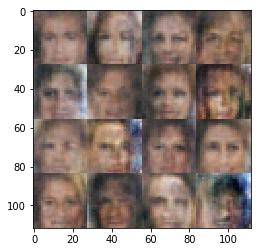

Epoch 1/1 Step 725/1582: Discriminator Loss: 0.3042. Generator Loss: 2.4198
Epoch 1/1 Step 730/1582: Discriminator Loss: 0.8748. Generator Loss: 0.7372
Epoch 1/1 Step 735/1582: Discriminator Loss: 0.3947. Generator Loss: 1.8489
generator out (?, 28, 28, 3)


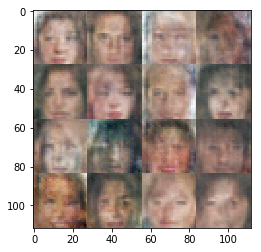

Epoch 1/1 Step 740/1582: Discriminator Loss: 1.0797. Generator Loss: 3.6094
Epoch 1/1 Step 745/1582: Discriminator Loss: 0.3017. Generator Loss: 2.1008
Epoch 1/1 Step 750/1582: Discriminator Loss: 0.2499. Generator Loss: 2.2430
generator out (?, 28, 28, 3)


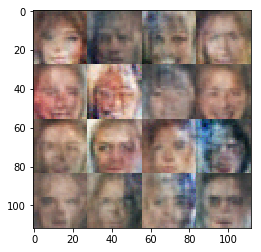

Epoch 1/1 Step 755/1582: Discriminator Loss: 0.1835. Generator Loss: 4.5764
Epoch 1/1 Step 760/1582: Discriminator Loss: 1.2410. Generator Loss: 0.5204
Epoch 1/1 Step 765/1582: Discriminator Loss: 0.9671. Generator Loss: 0.6654
generator out (?, 28, 28, 3)


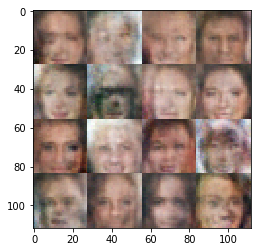

Epoch 1/1 Step 770/1582: Discriminator Loss: 1.1756. Generator Loss: 4.8896
Epoch 1/1 Step 775/1582: Discriminator Loss: 0.5462. Generator Loss: 1.4598
Epoch 1/1 Step 780/1582: Discriminator Loss: 0.4659. Generator Loss: 2.4064
generator out (?, 28, 28, 3)


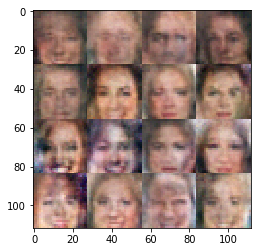

Epoch 1/1 Step 785/1582: Discriminator Loss: 0.3688. Generator Loss: 1.6393
Epoch 1/1 Step 790/1582: Discriminator Loss: 0.2451. Generator Loss: 3.0637
Epoch 1/1 Step 795/1582: Discriminator Loss: 0.2956. Generator Loss: 3.2519
generator out (?, 28, 28, 3)


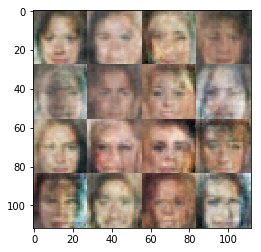

Epoch 1/1 Step 800/1582: Discriminator Loss: 0.2648. Generator Loss: 4.5317
Epoch 1/1 Step 805/1582: Discriminator Loss: 0.2884. Generator Loss: 2.2229
Epoch 1/1 Step 810/1582: Discriminator Loss: 0.2497. Generator Loss: 2.3695
generator out (?, 28, 28, 3)


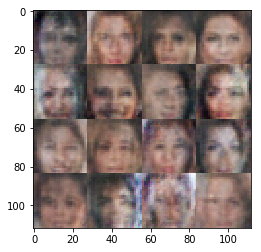

Epoch 1/1 Step 815/1582: Discriminator Loss: 0.8770. Generator Loss: 0.7499
Epoch 1/1 Step 820/1582: Discriminator Loss: 0.3186. Generator Loss: 2.9759
Epoch 1/1 Step 825/1582: Discriminator Loss: 0.1966. Generator Loss: 4.9479
generator out (?, 28, 28, 3)


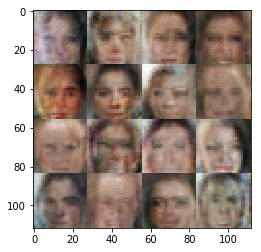

Epoch 1/1 Step 830/1582: Discriminator Loss: 0.3369. Generator Loss: 2.3347
Epoch 1/1 Step 835/1582: Discriminator Loss: 0.0757. Generator Loss: 6.1945
Epoch 1/1 Step 840/1582: Discriminator Loss: 0.3243. Generator Loss: 3.0291
generator out (?, 28, 28, 3)


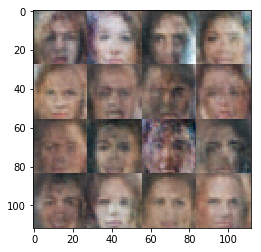

Epoch 1/1 Step 845/1582: Discriminator Loss: 0.7357. Generator Loss: 0.8864
Epoch 1/1 Step 850/1582: Discriminator Loss: 0.1350. Generator Loss: 4.1060
Epoch 1/1 Step 855/1582: Discriminator Loss: 0.1649. Generator Loss: 4.5311
generator out (?, 28, 28, 3)


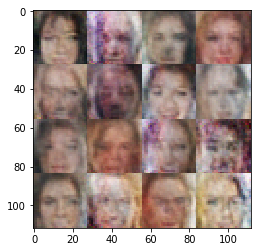

Epoch 1/1 Step 860/1582: Discriminator Loss: 0.1725. Generator Loss: 2.4669
Epoch 1/1 Step 865/1582: Discriminator Loss: 1.1060. Generator Loss: 0.5510
Epoch 1/1 Step 870/1582: Discriminator Loss: 0.2962. Generator Loss: 1.8110
generator out (?, 28, 28, 3)


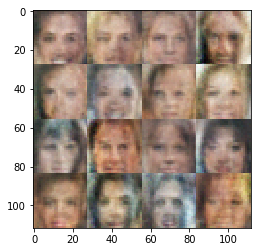

Epoch 1/1 Step 875/1582: Discriminator Loss: 1.2923. Generator Loss: 0.4115
Epoch 1/1 Step 880/1582: Discriminator Loss: 0.1536. Generator Loss: 4.5480
Epoch 1/1 Step 885/1582: Discriminator Loss: 0.1704. Generator Loss: 4.5586
generator out (?, 28, 28, 3)


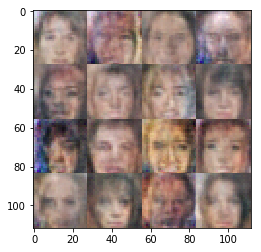

Epoch 1/1 Step 890/1582: Discriminator Loss: 0.1525. Generator Loss: 3.0689
Epoch 1/1 Step 895/1582: Discriminator Loss: 0.1879. Generator Loss: 2.5351
Epoch 1/1 Step 900/1582: Discriminator Loss: 0.1699. Generator Loss: 3.0079
generator out (?, 28, 28, 3)


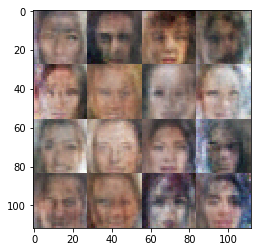

Epoch 1/1 Step 905/1582: Discriminator Loss: 1.2549. Generator Loss: 0.4728
Epoch 1/1 Step 910/1582: Discriminator Loss: 1.3669. Generator Loss: 0.4101
Epoch 1/1 Step 915/1582: Discriminator Loss: 0.2277. Generator Loss: 2.3916
generator out (?, 28, 28, 3)


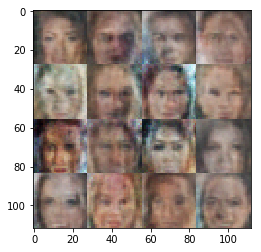

Epoch 1/1 Step 920/1582: Discriminator Loss: 0.1647. Generator Loss: 4.8220
Epoch 1/1 Step 925/1582: Discriminator Loss: 0.3094. Generator Loss: 7.0923
Epoch 1/1 Step 930/1582: Discriminator Loss: 0.1818. Generator Loss: 6.1695
generator out (?, 28, 28, 3)


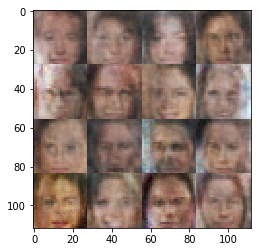

Epoch 1/1 Step 935/1582: Discriminator Loss: 0.0764. Generator Loss: 5.1539
Epoch 1/1 Step 940/1582: Discriminator Loss: 0.1795. Generator Loss: 6.8712
Epoch 1/1 Step 945/1582: Discriminator Loss: 0.2132. Generator Loss: 2.0959
generator out (?, 28, 28, 3)


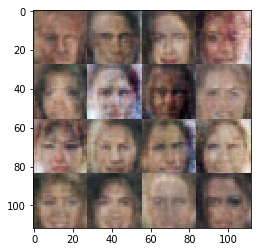

Epoch 1/1 Step 950/1582: Discriminator Loss: 0.2628. Generator Loss: 4.7395
Epoch 1/1 Step 955/1582: Discriminator Loss: 0.1627. Generator Loss: 8.9525
Epoch 1/1 Step 960/1582: Discriminator Loss: 0.4954. Generator Loss: 1.6629
generator out (?, 28, 28, 3)


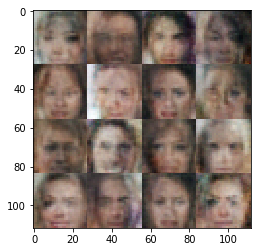

Epoch 1/1 Step 965/1582: Discriminator Loss: 0.1994. Generator Loss: 8.7667
Epoch 1/1 Step 970/1582: Discriminator Loss: 0.1506. Generator Loss: 7.5260
Epoch 1/1 Step 975/1582: Discriminator Loss: 0.3767. Generator Loss: 5.7982
generator out (?, 28, 28, 3)


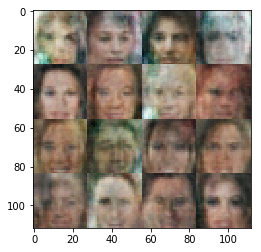

Epoch 1/1 Step 980/1582: Discriminator Loss: 0.0375. Generator Loss: 5.7187
Epoch 1/1 Step 985/1582: Discriminator Loss: 0.3786. Generator Loss: 1.7010
Epoch 1/1 Step 990/1582: Discriminator Loss: 0.0420. Generator Loss: 6.0101
generator out (?, 28, 28, 3)


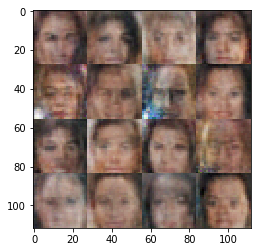

Epoch 1/1 Step 995/1582: Discriminator Loss: 0.0641. Generator Loss: 5.9147
Epoch 1/1 Step 1000/1582: Discriminator Loss: 0.0885. Generator Loss: 4.3309
Epoch 1/1 Step 1005/1582: Discriminator Loss: 0.4580. Generator Loss: 2.0837
generator out (?, 28, 28, 3)


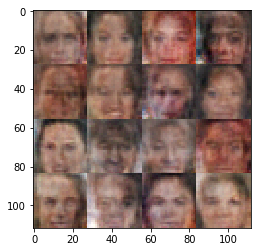

Epoch 1/1 Step 1010/1582: Discriminator Loss: 0.0512. Generator Loss: 5.7148
Epoch 1/1 Step 1015/1582: Discriminator Loss: 0.1352. Generator Loss: 3.4177
Epoch 1/1 Step 1020/1582: Discriminator Loss: 0.1063. Generator Loss: 3.2425
generator out (?, 28, 28, 3)


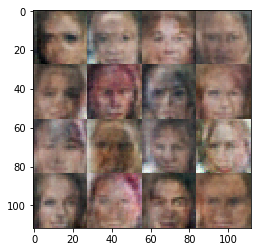

Epoch 1/1 Step 1025/1582: Discriminator Loss: 0.3532. Generator Loss: 6.2728
Epoch 1/1 Step 1030/1582: Discriminator Loss: 0.1279. Generator Loss: 4.2528
Epoch 1/1 Step 1035/1582: Discriminator Loss: 1.2202. Generator Loss: 7.9399
generator out (?, 28, 28, 3)


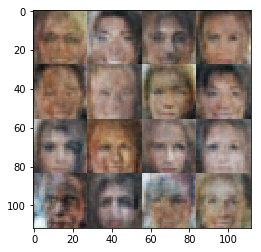

Epoch 1/1 Step 1040/1582: Discriminator Loss: 1.0810. Generator Loss: 0.5460
Epoch 1/1 Step 1045/1582: Discriminator Loss: 0.7422. Generator Loss: 0.8453
Epoch 1/1 Step 1050/1582: Discriminator Loss: 0.5022. Generator Loss: 5.0772
generator out (?, 28, 28, 3)


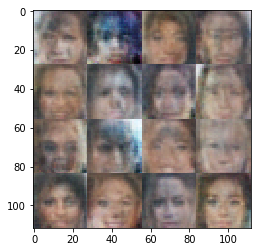

Epoch 1/1 Step 1055/1582: Discriminator Loss: 0.0576. Generator Loss: 4.7098
Epoch 1/1 Step 1060/1582: Discriminator Loss: 0.0891. Generator Loss: 6.5415
Epoch 1/1 Step 1065/1582: Discriminator Loss: 2.0120. Generator Loss: 6.5928
generator out (?, 28, 28, 3)


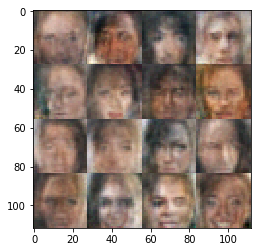

Epoch 1/1 Step 1070/1582: Discriminator Loss: 0.1369. Generator Loss: 2.7442
Epoch 1/1 Step 1075/1582: Discriminator Loss: 0.5077. Generator Loss: 1.8533


KeyboardInterrupt: 

In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.